# classes and functions

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import sys
import os
import glob
import configparser

import h5py
import numpy as np

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [4]:
class SingleModeNRWaveform(object):
    def __init__(self, nrfile, ell, mm, npts, t1=None, t2=None):

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2

        self.get_lm_mode(self.nrfile, ell, mm, self.npts)


    def get_lm_mode(self, nrfile, ell, mm, npts):
        
        if 'SXS' in nrfile:
            f = h5py.File(nrfile, 'r')

            self.q = f.attrs['mass1']/f.attrs['mass2']
            self.eta = f.attrs['eta']

            amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
            amp_x = amp_tmp['X'].value
            amp_y = amp_tmp['Y'].value

            phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
            phase_x = phase_tmp['X'].value
            phase_y = phase_tmp['Y'].value

            f.close()
        else:
            # bam
            self.sim_dir = os.path.dirname(nrfile)
            self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
            # strict=False because of DuplicateSectionError
            config = configparser.ConfigParser(strict=False)

            config.read(self.bbh_file)
            mass1_tmp = float(config['metadata']['mass1'])
            mass2_tmp = float(config['metadata']['mass2'])
            self.initial_sep = float(config['metadata']['initial-separation'])

            if mass1_tmp >= mass2_tmp:
                mass1 = mass1_tmp
                mass2 = mass2_tmp
            else:
                mass1 = mass2_tmp
                mass2 = mass1_tmp


            self.mass1 = mass1
            self.mass2 = mass2
            self.mtot = self.mass1 + self.mass2
            self.q = self.mass1 / self.mass2
            self.eta = self.mass1 * self.mass2 / (self.mtot)**2.
            
            times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

            # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
            hlm = re_hlm - 1.j * im_hlm
            
            amp_x = times
            amp_y = np.abs(hlm)

            phase_x = times
            phase_y = np.unwrap(np.angle(hlm))
            
            
        # shift so that amp peak is at t=0 - will need to be more careful with HMs
        amp_peak_idx = amp_y.argmax()
        amp_peak_time = amp_x[amp_peak_idx]
        amp_x = amp_x - amp_peak_time
        phase_x = phase_x - amp_peak_time
            

        amp_i = IUS(amp_x, amp_y)
        phase_i = IUS(phase_x, phase_y)

        if self.t1 is None:
            self.t1 = max(amp_x[0], phase_x[0])
        if self.t2 is None:
            self.t2 = min(amp_x[-1], phase_x[-1])
            
        # t1,t2=-600,100

        common_times = np.linspace(self.t1, self.t2, npts)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        self.times = common_times
        self.amp = amplist
        self.phi = phaselist
        # self.hlm["{0}, {1}".format(ell, mm)] = self.amp * np.exp(-1.j * self.phi)
        self.hlm = self.amp * np.exp(-1.j * self.phi)
        

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [5]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.2f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        # index of maximum
        max_idx_hlm = self.hlm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_hlm = self.nrdata.times[max_idx_hlm]
        
        self.times_hlm = self.nrdata.times - self.time_at_max_idx_hlm
        

        # news
        newslmre = ihlmre.derivative()(self.times_hlm)
        newslmim = ihlmim.derivative()(self.times_hlm)

        self.newslm = newslmre - 1.j*newslmim
        
        self.newslm_amp = np.abs(self.newslm)
        
        # index of maximum
        max_idx_news = self.newslm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_news = self.nrdata.times[max_idx_news]
        
        self.times_news = self.nrdata.times - self.time_at_max_idx_news
        
        self.newslm_phase = np.unwrap(np.angle(self.newslm))
        i_newslm_phase = IUS(self.times_news, self.newslm_phase)
        self.newslm_ang_freq = i_newslm_phase.derivative()(self.times_news)
        
        
        
        # psi4
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        
    
    
        # time shift between peak of strain and peak of psi4
        # index of maximum
        hlm_max_idx = self.hlm_amp.argmax()
        # time of maximum
        self.hlm_time_at_max_idx = self.nrdata.times[hlm_max_idx]

In [6]:
# get data
nrfiles = dict(
    q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
    q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
    q18="/Users/spx8sk/work/data/q18a0a0c025_144/h3col.r7.l5.l2.m2"
)

In [7]:
ell = 2
mm = 2

npts_time = 1000*3
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
# t1=-600
# t1=-1000
t1=-800
t2=60


In [8]:
psi4s = {}
for k,v in list(nrfiles.items()):
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [9]:
for k in psi4s.keys():
    print("{} = {}".format(k, 1./psi4s[k].fdamp/2/np.pi))

q1 = 11.706422641558191
q2 = 11.554740530290251
q4 = 11.36516841490208
q5 = 11.32930696199893
q10 = 11.272552160962043
q18 = 11.255711435422901


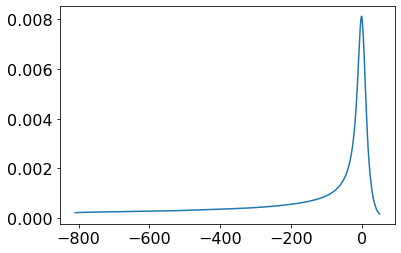

In [10]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_amp)

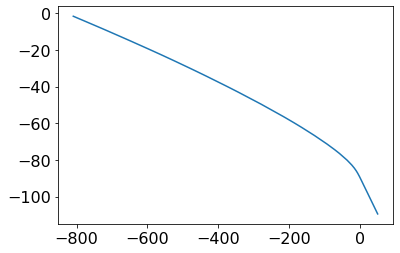

In [11]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_phase)

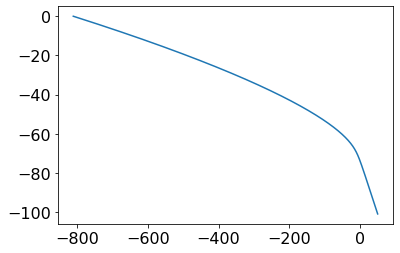

In [12]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_phase)

Text(0.5, 1.0, '$|h|(t)$')

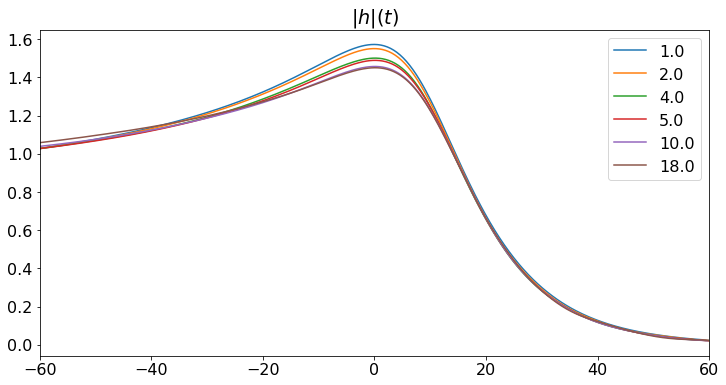

In [13]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
#     plt.plot(psi4s[k].times, psi4s[k].hlm_amp, label=psi4s[k].q)
plt.legend()
plt.xlim(-60,60)
# plt.ylim(0.2, 1.6)
# plt.yscale('log')
plt.title(r'$|h|(t)$')

Text(0.5, 1.0, '$|N|(t)$')

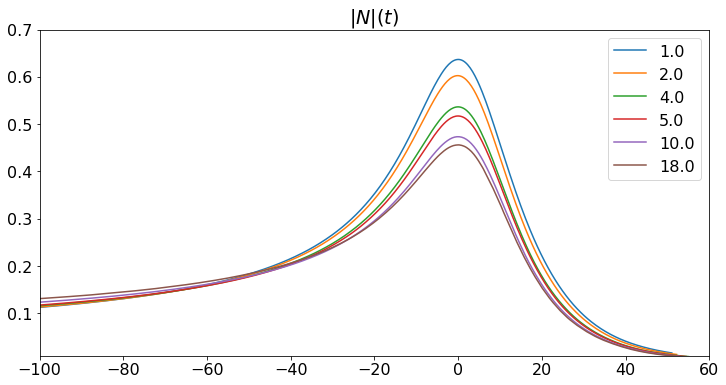

In [14]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.7)
# plt.yscale('log')
plt.title(r'$|N|(t)$')

Text(0.5, 1.0, '$|\\Psi_4|(t)$')

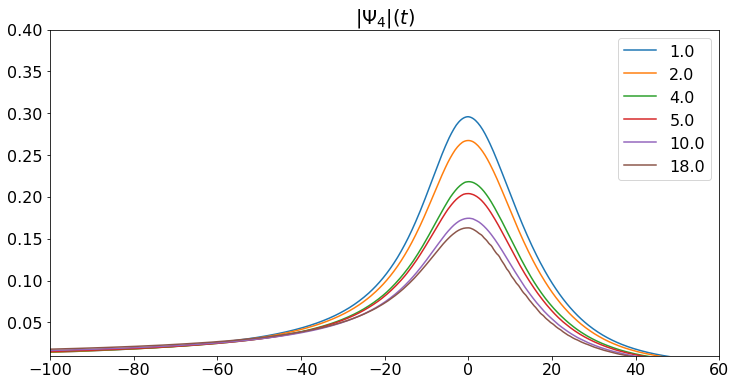

In [15]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.4)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $h$')

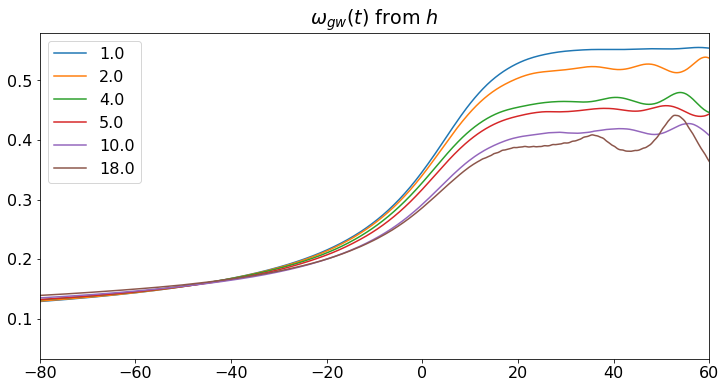

In [16]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $h$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from News')

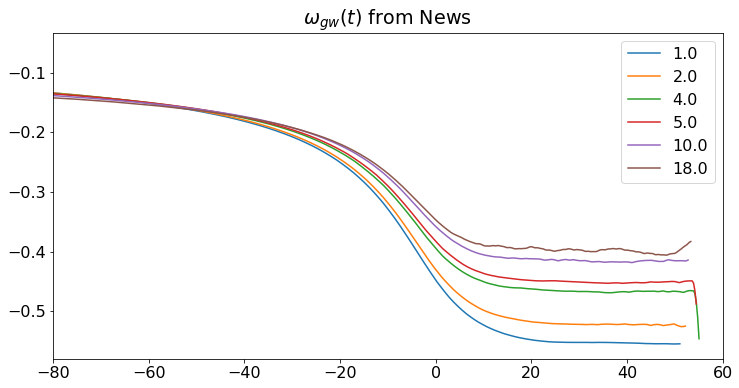

In [17]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from News')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $\\Psi_4$')

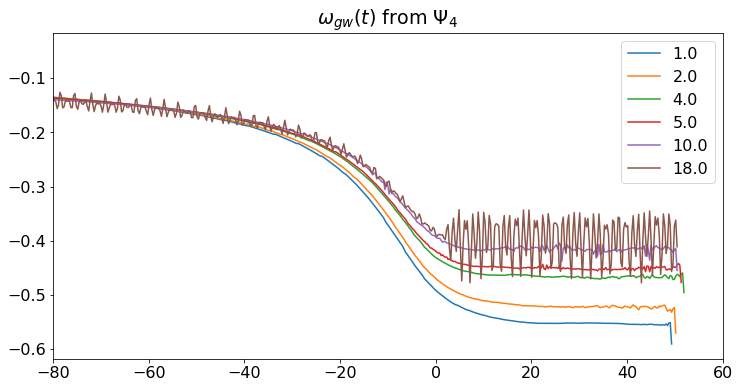

In [18]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $\Psi_4$')

Text(0.5, 1.0, 'q = 18.0')

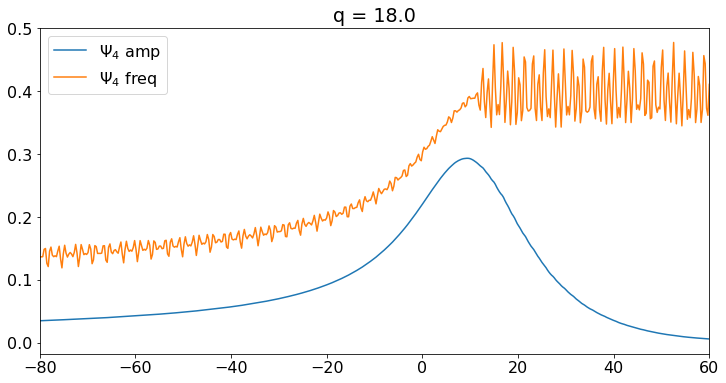

In [19]:
# compare psi4_amp and freq
k = 'q18'

plt.figure(figsize=(12, 6))
plt.plot(psi4s[k].nrdata.times, psi4s[k].psi4lm_amp / psi4s[k].eta * 1.8, label='$\Psi_4$ amp')
plt.plot(psi4s[k].nrdata.times, -psi4s[k].psi4lm_ang_freq, label='$\Psi_4$ freq')
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'q = {}'.format(psi4s[k].q))

# freq modelling

## intermediate and merger-ringdown

In [20]:
# intermediate model
class Model(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2 + a2 / (t - tp)**3 + a3 / (t - tp)**4
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]


        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tdamp', value=20., min=-1000, max=1000)
        
        params.add('tp', value=20, min=-300, max=300)
        
#         params.add('tp', value=20, min=-10, max=50)
        
        params.add('lor_amp', value=20., min=-2000, max=2000)
        params.add('a0', value=0., min=-2000, max=200, vary=True)
        params.add('a1', value=0., min=-4000, max=4000, vary=False)
        params.add('a2', value=0., min=-200, max=800, vary=False)
        params.add('a3', value=0., min=-200, max=800, vary=False)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [21]:
# merger ringdown
class Model3(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']
        
        c = params['c']
        d = params['d']
        e = params['e']

        dt = t - t0
#         num = 1. + np.tanh(np.log(np.sqrt(kappa)) - (dt/b))
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * ((num/den)**(kappa))
#         model = offset + (om_f - offset) * (((num/den)**kappa) + c*dt + d*dt**2+ e/dt)
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]


        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('t0', value=5., min=-20, max=20)
        params.add('kappa', value=1, vary=True)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('om_f', value=self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0.2, min=1e-2, max=200)
        
        params.add('c', value=0, min=-200, max=200, vary=False)
        params.add('d', value=0, min=-200, max=200, vary=False)
        params.add('e', value=0, min=-200, max=200, vary=False)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

In [22]:
# psi4s[k].nrdata.times, -psi4s[k].psi4lm_ang_freq

In [23]:
# k = 'q1'
# k = 'q5'
# k = 'q10'
# k = 'q18'

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 174
    # variables        = 3
    chi-square         = 0.00185552
    reduced chi-square = 1.0851e-05
    Akaike info crit   = -1986.06440
    Bayesian info crit = -1976.58723
[[Variables]]
    t0:      6.60891965 +/- 0.61416277 (9.29%) (init = 5)
    kappa:   0.53342949 +/- 0.06863693 (12.87%) (init = 1)
    b:       11.25571 (fixed)
    om_f:    0.397943 (fixed)
    offset:  0.19137516 +/- 0.00920161 (4.81%) (init = 0.2)
    c:       0 (fixed)
    d:       0 (fixed)
    e:       0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, offset) =  0.987
    C(t0, kappa)     = -0.980
    C(t0, offset)    = -0.939


Text(0.5, 1.0, '% error')

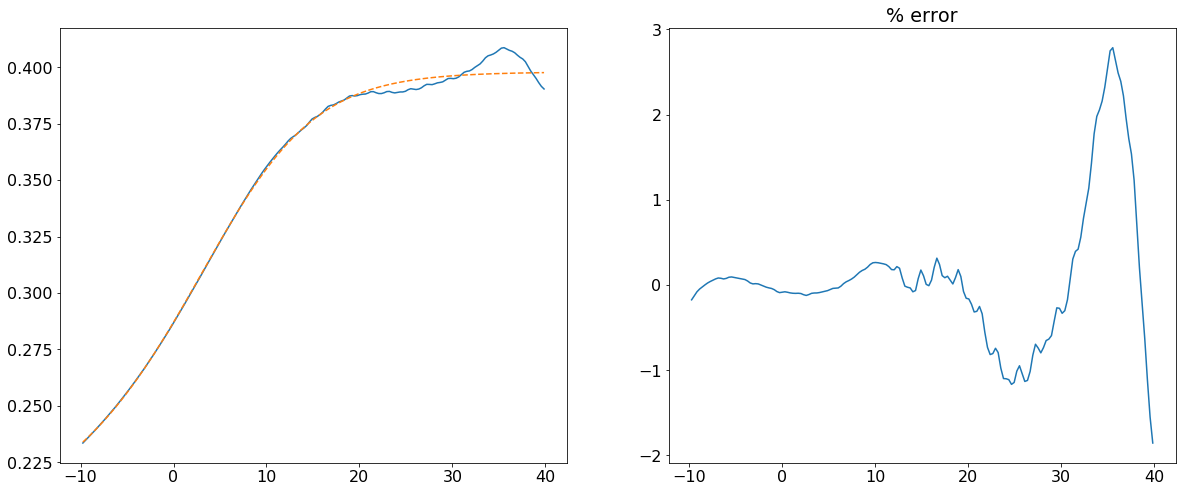

In [24]:
q1_fit_3 = Model3(psi4s[k])
# q1_fit_3.fit_freq_mr(t1=-30, t2=40)

# this is the standard
# q1_fit_3.fit_freq_mr(t1=-10, t2=40)


q1_fit_3.fit_freq_mr(t1=-10, t2=40)
# q1_fit_3.fit_freq_mr(t1=-100, t2=50)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_3.fit_times, q1_fit_3.fit_data)
axes[0].plot(q1_fit_3.fit_times, q1_fit_3.freq_mr_final, ls='--')


aa = q1_fit_3.fit_data
bb = q1_fit_3.freq_mr_final

axes[1].plot(q1_fit_3.fit_times, 100*(aa-bb)/aa)
axes[1].set_title("% error")

# extrapolate
# xs = np.linspace(-30,200,100)
# ys_mr = q1_fit_3.model_freq_mr(q1_fit_3.freq_mr_result.params, xs)
# axes[0].plot(xs,ys_mr)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 192
    # variables        = 4
    chi-square         = 8.5066e-07
    reduced chi-square = 4.5248e-09
    Akaike info crit   = -3685.07224
    Bayesian info crit = -3672.04226
[[Variables]]
    tdamp:    69.4629568 +/- 0.27851618 (0.40%) (init = 20)
    tp:       53.6093499 +/- 0.16338750 (0.30%) (init = 20)
    lor_amp: -41.7926114 +/- 0.22882053 (0.55%) (init = 20)
    a0:      -35.6078144 +/- 0.14882335 (0.42%) (init = 0)
    a1:       0 (fixed)
    a2:       0 (fixed)
    a3:       0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(tdamp, tp)      =  0.999
    C(lor_amp, a0)    =  0.999
    C(tdamp, a0)      = -0.992
    C(tp, a0)         = -0.987
    C(tdamp, lor_amp) = -0.985
    C(tp, lor_amp)    = -0.977


(-0.4, 0.4)

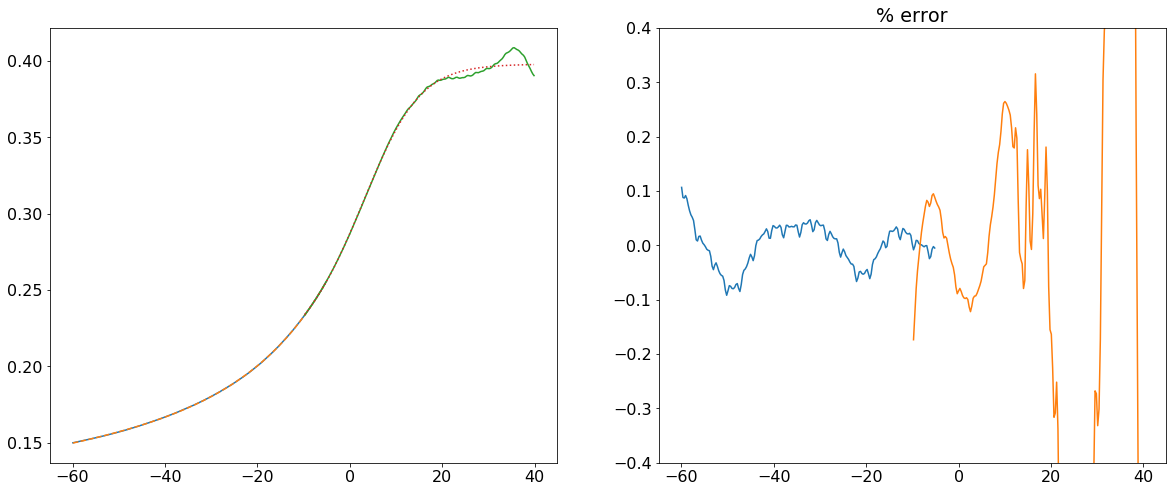

In [25]:
q1_fit = Model(psi4s[k])
# q1_fit.fit_freq_mr(t1=-100, t2=0)
# q1_fit.fit_freq_mr(t1=-100, t2=-5


# the current standard
# q1_fit.fit_freq_mr(t1=-100, t2=5)

q1_fit.fit_freq_mr(t1=-60, t2=-5)

# q1_fit.fit_freq_mr(t1=-500, t2=5)

# q1_fit.fit_freq_mr(t1=-200, t2=-5)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit.fit_times, q1_fit.fit_data)
axes[0].plot(q1_fit.fit_times, q1_fit.freq_mr_final, ls='--')


axes[1].plot(q1_fit.fit_times, 100*(q1_fit.fit_data - q1_fit.freq_mr_final)/q1_fit.fit_data)




axes[0].plot(q1_fit_3.fit_times, q1_fit_3.fit_data)
axes[0].plot(q1_fit_3.fit_times, q1_fit_3.freq_mr_final, ls=':')


axes[1].plot(q1_fit_3.fit_times, 100*(q1_fit_3.fit_data - q1_fit_3.freq_mr_final)/q1_fit_3.fit_data)


# extrapolate
# xs = np.linspace(-100,20,100)
# ys = q1_fit.model_freq_mr(q1_fit.freq_mr_result.params, xs)
# axes[0].plot(xs,ys)
# axes[0].set_yscale('log')

axes[1].set_title("% error")

axes[1].set_ylim(-0.4,0.4)

## inspiral

In [26]:
# Newton gravity constant
# lal.G_SI: 6.67384e-11
G_Newt = 6.67384e-11

In [27]:
# light speed
# lal.C_SI: 299792458.0
c_ls = 299792458.0

In [28]:
# lal.MSUN_SI: 1.9885469549614615e+30
MSUN_SI = 1.9885469549614615e+30

In [29]:
MTSUN_SI = 4.925491025543576e-06

In [30]:
# lal.MRSUN_SI: 1476.6250614046494
MRSUN_SI = 1476.6250614046494

In [31]:
# lal.PC_SI: 3.085677581491367e+16
PC_SI = 3.085677581491367e+16

In [32]:
# lal.GAMMA: 0.5772156649015329
GAMMA = 0.5772156649015329

In [33]:
def Msun_to_sec(M):
    """
    convert mass (in units of solar masses)
    into seconds
    """
#     return M *lal.MSUN_SI* G_Newt / c_ls**3.
    return M * MTSUN_SI

In [34]:
def TaylorT3_Omega_new(t, tc, eta, M):
    """
    22 mode angular GW frequency
    equation 7 in 0901.2437
    
    3.5PN term from https://arxiv.org/pdf/gr-qc/0610122.pdf and https://arxiv.org/pdf/0907.0700.pdf
    and this too apparently https://arxiv.org/pdf/gr-qc/0406012.pdf?
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralTaylorT3.c
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralPNCoefficients.c
    
    t: time
    tc: coalescence time
    eta: symmetric mass ratio
    M: total mass (Msun)
    """
    
    Msec = Msun_to_sec(M)
    Msec = M
    
    pi2 = np.pi*np.pi
    
    c1 = eta/(5.*Msec)
    
    td = c1 * (tc - t)
    
#     td = np.sqrt(td**2 + 1)
    
    theta = td**(-1./8.) # -1./8. = -0.125 
    
    theta2 = theta*theta
    theta3 = theta2*theta
    theta4 = theta3*theta
    theta5 = theta4*theta
    theta6 = theta5*theta
    theta7 = theta6*theta

    # pre factor
    ftaN = 1. / ( 8. * np.pi * Msec  )
    # 0PN
    fts1 = 1.
    # 0.5PN = 0 in GR
    # 1PN
    fta2 = 7.43/26.88 + 1.1/3.2 * eta
    # 1.5PN
    fta3 = -3./10. * np.pi
    # 2PN
    fta4 = 1.855099/14.450688 + 5.6975/25.8048 * eta + 3.71/20.48 * eta*eta
    # 2.5PN
    fta5 = (-7.729/21.504 + 1.3/25.6 * eta) * np.pi
    # 3PN
    fta6 = -7.20817631400877/2.88412611379200 + 5.3/20.0 * pi2 + 1.07/2.80 * GAMMA  \
           + (25.302017977/4.161798144 - 4.51/20.48 * pi2) * eta \
           - 3.0913/183.5008 * eta*eta + 2.35925/17.69472 * eta*eta*eta
            
    # 3.5PN
    fta7 = (-1.88516689/4.33520640 - 9.7765/25.8048 * eta + 1.41769/12.90240 * eta*eta) * np.pi

    # 3PN log term
    ftal6 = 1.07/2.80
    

    full = theta3*ftaN * (1. \
             + fta2*theta2 \
             + fta3*theta3 \
             + fta4*theta4 \
             + fta5*theta5 \
             + (fta6 + ftal6*np.log(2.*theta))*theta6 \
             + fta7*theta7)
    
    return full * 2 * np.pi # 2pi to go from freq to angular freq

In [35]:
class Inspiral_Model(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
        tc = params['tc']
        b = params['b']
        c = params['c']
        d = params['d']
        nu = self.Psi4.eta
        M = 1
        
        tau = nu * (tc - t) / (5*M)
#         tau = np.sqrt((nu * (tc - t) / (5*M))**2 + 1)
        
#         model = (TaylorT3_Omega(t, tc, nu, M) + b*tau**(-7./8.) + c*tau**(-9./8.) + d*tau**(-10./8.))
#         model = (TaylorT3_Omega_new(t, tc, nu, M) + b*tau**(-7./8.) + c*tau**(-9./8.) + d*tau**(-10./8.))


#         model = (TaylorT3_Omega_new(t, tc, nu, M) + b*tau**(-9./8.) + c*tau**(-10./8.) + d*tau**(-11./8.))
        model = (TaylorT3_Omega_new(t, 1000, nu, M) + b*tau**(-9./8.) + c*tau**(-10./8.) + d*tau**(-11./8.))
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):

        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tc', value=20., min=-5, max=400)
        
        params.add('b', value=0, min=-300, max=300, vary=True)
        params.add('c', value=0., min=-2000, max=2000, vary=True)
        params.add('d', value=0., min=-2000, max=2000, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 103
    # data points      = 2685
    # variables        = 4
    chi-square         = 2.2317e-04
    reduced chi-square = 8.3243e-08
    Akaike info crit   = -43765.5480
    Bayesian info crit = -43741.9662
[[Variables]]
    tc:  42.3634881 +/- 0.34385139 (0.81%) (init = 20)
    b:   2.70929379 +/- 0.00575464 (0.21%) (init = 0)
    c:  -4.87728928 +/- 0.01312665 (0.27%) (init = 0)
    d:   2.26798222 +/- 0.00760920 (0.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c)  = -0.999
    C(c, d)  = -0.999
    C(b, d)  =  0.998
    C(tc, d) =  0.919
    C(tc, c) = -0.905
    C(tc, b) =  0.893


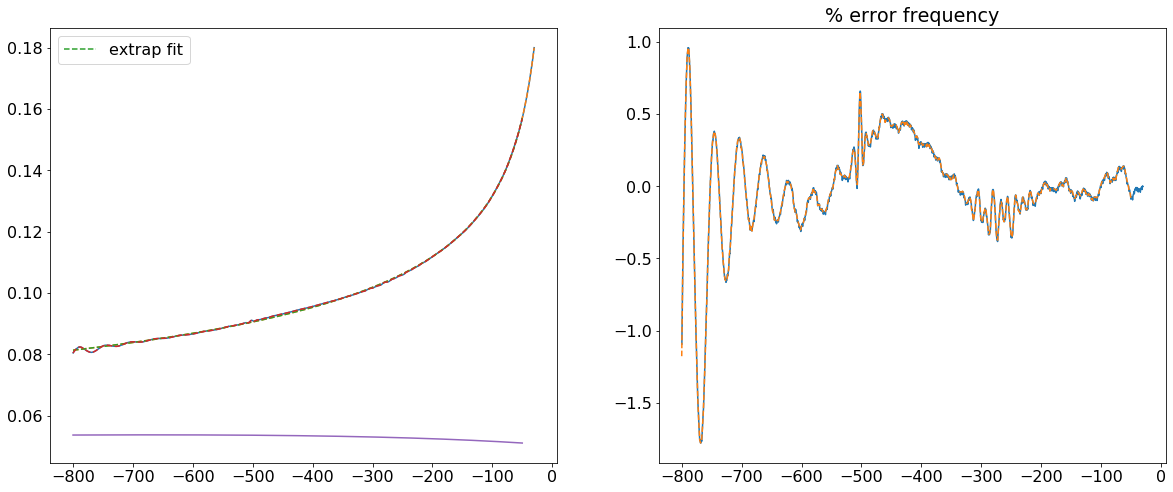

In [36]:
q1_fit_ins = Inspiral_Model(psi4s[k])


# the current standard
# q1_fit_ins.fit_freq_mr(t1=-800, t2=-50)

q1_fit_ins.fit_freq_mr(t1=-800, t2=-30)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_ins.fit_times, q1_fit_ins.fit_data)
axes[0].plot(q1_fit_ins.fit_times, q1_fit_ins.freq_mr_final, ls='--')


axes[1].plot(q1_fit_ins.fit_times, 100*(q1_fit_ins.fit_data - q1_fit_ins.freq_mr_final)/q1_fit_ins.fit_data)
axes[1].set_title('% error frequency')

# extrapolate
xs = np.linspace(-800,-50,500)
ys = q1_fit_ins.model_freq_mr(q1_fit_ins.freq_mr_result.params, xs)

iy_nr = IUS(psi4s[k].times_hlm, psi4s[k].hlm_ang_freq)
y_nr = iy_nr(xs)




axes[0].plot(xs,ys, ls='--', label='extrap fit')
axes[0].plot(xs,y_nr, ls='--')

axes[1].plot(xs,100*(y_nr-ys)/y_nr, ls='--')

axes[0].legend()

# plot PN
y_pn = TaylorT3_Omega_new(xs, 1000, psi4s[k].eta, 1)
axes[0].plot(xs, y_pn)

### putting it together

Text(0.5, 1.0, '% error frequency')

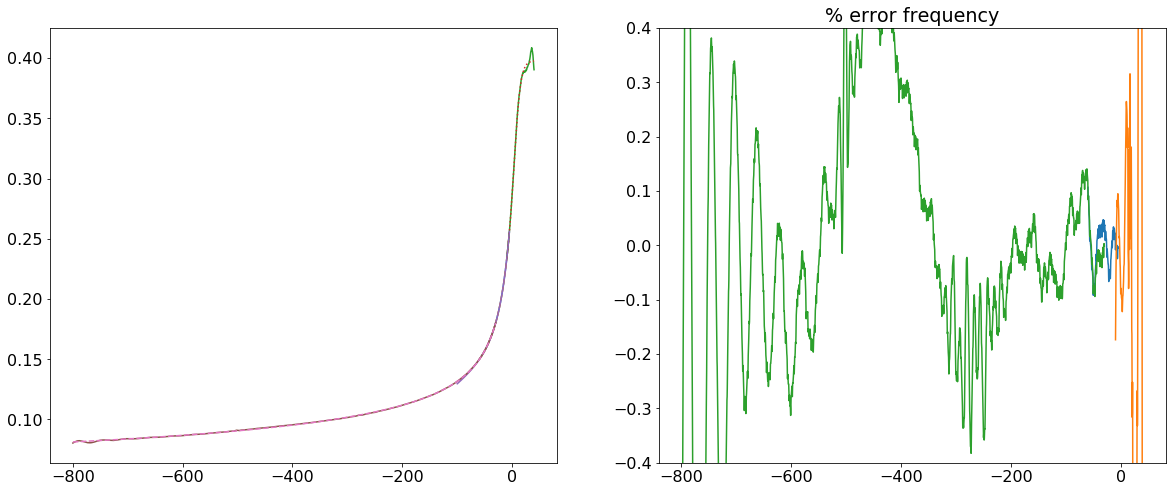

In [37]:
# the current standard
# q1_fit.fit_freq_mr(t1=-100, t2=5)

# q1_fit.fit_freq_mr(t1=-500, t2=5)

# q1_fit.fit_freq_mr(t1=-200, t2=-5)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit.fit_times, q1_fit.fit_data)
axes[0].plot(q1_fit.fit_times, q1_fit.freq_mr_final, ls='--')


axes[1].plot(q1_fit.fit_times, 100*(q1_fit.fit_data - q1_fit.freq_mr_final)/q1_fit.fit_data)




axes[0].plot(q1_fit_3.fit_times, q1_fit_3.fit_data)
axes[0].plot(q1_fit_3.fit_times, q1_fit_3.freq_mr_final, ls=':')


axes[1].plot(q1_fit_3.fit_times, 100*(q1_fit_3.fit_data - q1_fit_3.freq_mr_final)/q1_fit_3.fit_data)


# extrapolate
xs = np.linspace(-100,-5,100)
ys = q1_fit.model_freq_mr(q1_fit.freq_mr_result.params, xs)
axes[0].plot(xs,ys)
# axes[0].set_yscale('log')

axes[1].set_title("% error")

axes[1].set_ylim(-0.4,0.4)


axes[0].plot(q1_fit_ins.fit_times, q1_fit_ins.fit_data)
axes[0].plot(q1_fit_ins.fit_times, q1_fit_ins.freq_mr_final, ls='--')


axes[1].plot(q1_fit_ins.fit_times, 100*(q1_fit_ins.fit_data - q1_fit_ins.freq_mr_final)/q1_fit_ins.fit_data)
axes[1].set_title('% error frequency')


# axes[1].set_xlim(-500, 10)

## full inspiral and MR 'model'

(0.14, 0.3)

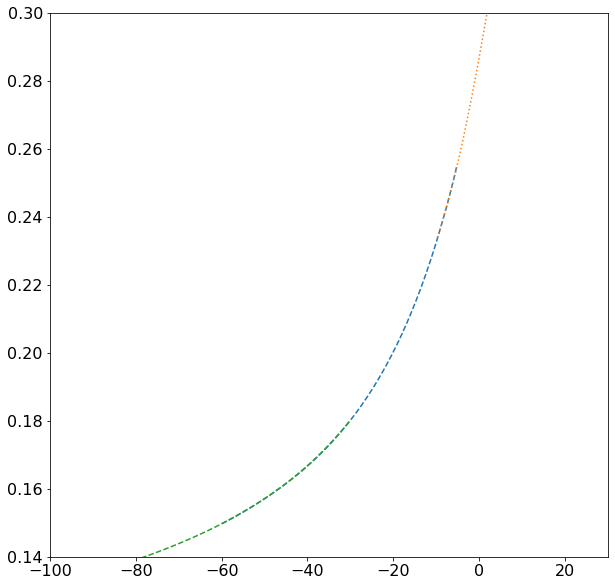

In [38]:
plt.figure(figsize=(10,10))

plt.plot(q1_fit.fit_times, q1_fit.freq_mr_final, ls='--')
plt.plot(q1_fit_3.fit_times, q1_fit_3.freq_mr_final, ls=':')
plt.plot(q1_fit_ins.fit_times, q1_fit_ins.freq_mr_final, ls='--')
plt.xlim(-100, 30)
plt.ylim(0.14,0.3)

In [39]:
ins_xs = np.linspace(-1000,-50,5000)
ins_ys = q1_fit_ins.model_freq_mr(q1_fit_ins.freq_mr_result.params, ins_xs)

In [40]:
# inspiral upto t=-40
# intermediate from t=-40 to t=-10
# mr from t=-10 until the end
# ins_mask = q1_fit_ins.fit_times <= -40
ins_mask = ins_xs <= -40
int_mask = (q1_fit.fit_times > -40) & (q1_fit.fit_times <= -10)
mr_mask = q1_fit_3.fit_times > -10

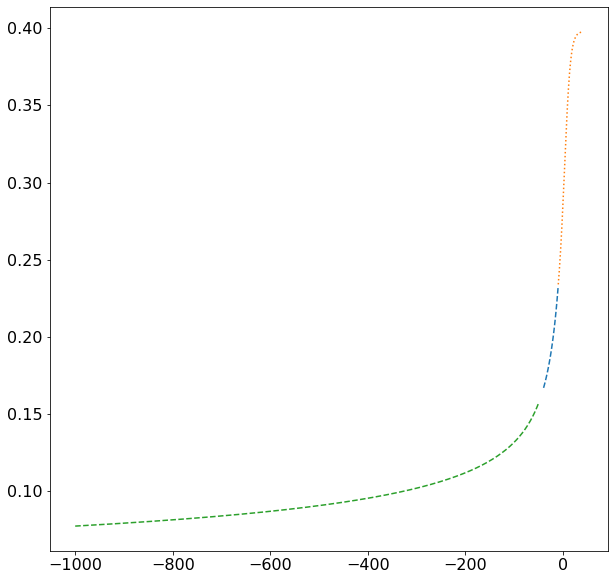

In [41]:
plt.figure(figsize=(10,10))

plt.plot(q1_fit.fit_times[int_mask], q1_fit.freq_mr_final[int_mask], ls='--')
plt.plot(q1_fit_3.fit_times[mr_mask], q1_fit_3.freq_mr_final[mr_mask], ls=':')
# plt.plot(q1_fit_ins.fit_times[ins_mask], q1_fit_ins.freq_mr_final[ins_mask], ls='--')
plt.plot(ins_xs[ins_mask], ins_ys[ins_mask], ls='--')
# plt.xlim(-100, 30)
# plt.ylim(0.14,0.3)

In [42]:
full_times = np.concatenate((ins_xs[ins_mask],q1_fit.fit_times[int_mask],q1_fit_3.fit_times[mr_mask]))
full_freq = np.concatenate((ins_ys[ins_mask],q1_fit.freq_mr_final[int_mask],q1_fit_3.freq_mr_final[mr_mask]))

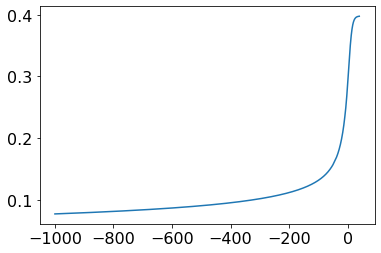

In [43]:
plt.figure()
plt.plot(full_times, full_freq)

In [44]:
i_full_freq = IUS(full_times, full_freq)

In [45]:
i_full_freq(-500)

array(0.09056082)

# inspiral amp modelling

In [46]:
def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in Mpc
    M*G/c^2 * M_sun / dist
    """
    return mtot * MRSUN_SI / (distance * 1e6*PC_SI)

In [47]:
td_amp_scale(100, 1)

4.785415917274702e-18

In [48]:
# k = 'q1'
# k = 'q18'

In [49]:
phenom.eta_from_q(100)

0.009802960494069209

In [50]:
import lal
from pycbc import waveform

mmtot = 50

mm1 = mass1_from_mtotal_eta(mmtot, psi4s[k].eta)
mm2 = mass2_from_mtotal_eta(mmtot, psi4s[k].eta)


t3hp, t3hc = waveform.get_td_waveform(approximant='TaylorT3', mass1=mm1, mass2=mm2, f_lower=14, delta_t=1./4096)
t3amp = waveform.amplitude_from_polarizations(t3hp, t3hc)

t3_t_M = phenom.StoM(t3amp.sample_times, mmtot)


# to go from polarisation to hlm modes divide by amp prefactor and Ylm
t3_amp = t3amp.numpy() / td_amp_scale(mmtot, 1) / np.abs(lal.SpinWeightedSphericalHarmonic(0, 0, -2, 2, 2))

In [51]:
t3hp.numpy()

ArrayWithAligned([-2.18264489e-20, -2.19199134e-20, -2.20032689e-20, ...,
                  -3.92294670e-20, -3.85806508e-20, -3.78225171e-20])

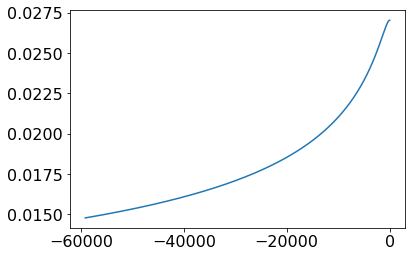

In [52]:
plt.figure()
plt.plot(t3_t_M, t3_amp)

Text(0.5, 1.0, '$|h|(t)$')

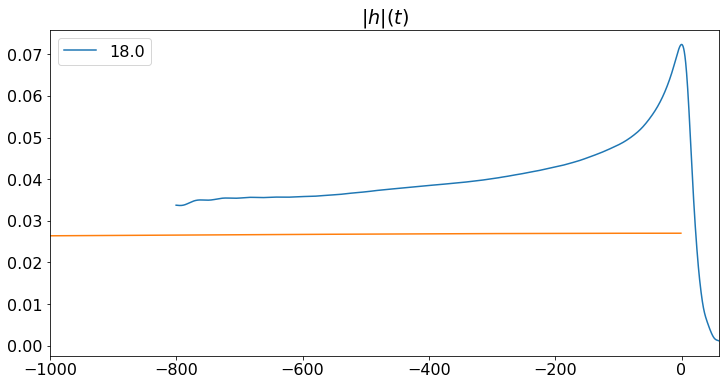

In [53]:

plt.figure(figsize=(12, 6))
plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp, label=psi4s[k].q)

plt.plot(t3_t_M, t3_amp)

plt.legend()
plt.xlim(-1000,60)
# plt.ylim(0.2, 1.6)
# plt.yscale('log')
plt.title(r'$|h|(t)$')

## try fitting T3 data + extra terms

In [54]:
# inspiral amp model
class Model_Ins_Amp(object):
    def __init__(self, Psi4, T3times, T3amp):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        self.T3times = T3times
        self.T3amp = T3amp
        
    def model_freq_mr(self, params, t):
        

        t0 = params['t0']
        
        a0 = params['a0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        
#         model = self.T3amp_masked + a0*(t0-t)**(-7./8.) + a1*(t0-t)**(-9./8.) + a2*(t0-t)**(-10./8.) + a3*(t0-t)**(-11./8.)
#         model = self.T3amp_masked + a0*(t0-t)**(-8./8.) + a1*(t0-t)**(-9./8.) + a2*(t0-t)**(-10./8.) + a3*(t0-t)**(-11./8.)
        model = self.T3amp_masked + a0*(t0-t)**(-9./8.) + a1*(t0-t)**(-10./8.) + a2*(t0-t)**(-11./8.) + a3*(t0-t)**(-12./8.)
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]


        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_amp[self.model_freq_mr_mask]
        
        self.iT3 = IUS(self.T3times, self.T3amp)
        self.T3amp_masked = self.iT3(self.fit_times)
        
#         self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask] - self.T3amp_masked
        
        # create a set of Parameters
        params = Parameters()
        
#         params.add('t0', value=0., min=-200, max=200, vary=True)
#         params.add('a0', value=0., min=-2000, max=200, vary=True)
#         params.add('a1', value=0., min=-4000, max=4000, vary=True)
#         params.add('a2', value=0., min=-4000, max=800, vary=True)
#         params.add('a3', value=0., min=-4000, max=2000, vary=True)

        params.add('t0', value=0., min=-200, max=200, vary=True)
        params.add('a0', value=0., min=-2000, max=200, vary=True)
        params.add('a1', value=100., min=-200, max=4000, vary=True)
        params.add('a2', value=0., min=-8000, max=800, vary=True)
        params.add('a3', value=0., min=-4000, max=5000, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5016
    # data points      = 2023
    # variables        = 5
    chi-square         = 1.7067e-05
    reduced chi-square = 8.4575e-09
    Akaike info crit   = -37598.9522
    Bayesian info crit = -37570.8905
[[Variables]]
    t0:  87.6793923 +/- 1.65221122 (1.88%) (init = 0)
    a0: -124.716989 +/- 21.2425836 (17.03%) (init = 0)
    a1:  1208.90015 +/- 133.270648 (11.02%) (init = 100)
    a2: -3095.10030 +/- 278.541756 (9.00%) (init = 0)
    a3:  2422.66502 +/- 194.215969 (8.02%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, a3) = -1.000
    C(a1, a2) = -1.000
    C(a0, a1) = -1.000
    C(a1, a3) =  1.000
    C(a0, a2) =  1.000
    C(a0, a3) = -0.999
    C(t0, a3) =  0.978
    C(t0, a2) = -0.975
    C(t0, a1) =  0.972
    C(t0, a0) = -0.969


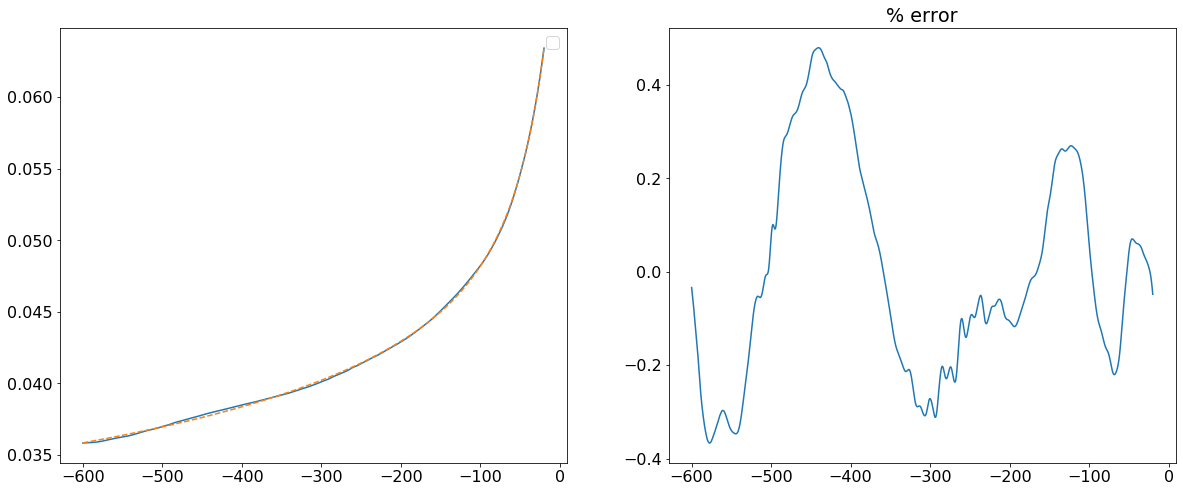

In [55]:


q1_fit_amp_ins = Model_Ins_Amp(psi4s[k],t3_t_M, t3_amp)

# the current standard
q1_fit_amp_ins.fit_freq_mr(t1=-600, t2=-20)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_amp_ins.fit_times, q1_fit_amp_ins.fit_data)
axes[0].plot(q1_fit_amp_ins.fit_times, q1_fit_amp_ins.freq_mr_final, ls='--')


axes[1].plot(q1_fit_amp_ins.fit_times, 100*(q1_fit_amp_ins.fit_data - q1_fit_amp_ins.freq_mr_final)/q1_fit_amp_ins.fit_data)




axes[1].set_title("% error")

# axes[1].set_ylim(-0.4,0.4)


# extrapolate
# xs = np.linspace(-12000,-50,5000)


# q1_fit_amp_ins.T3amp_masked = q1_fit_amp_ins.iT3(xs)
# ys = q1_fit_amp_ins.model_freq_mr(q1_fit_amp_ins.freq_mr_result.params, xs)

# iy_nr = IUS(psi4s[k].times_hlm, psi4s[k].hlm_amp)
# y_nr = iy_nr(xs)


# axes[0].plot(xs,ys, ls='--', label='extrap fit')
# axes[0].plot(xs,y_nr, ls='--')

# axes[1].plot(xs,100*(y_nr-ys)/y_nr, ls='--')

axes[0].legend()

# axes[0].plot(t3_t_M, t3_amp)

# axes[1].set_xlim(-100, 20)

## PN amplitude

In [56]:
# https://arxiv.org/pdf/0802.1249.pdf - eq. 9.4a
def Hhat22(t, t0, eta, M):

    GW22AngFreq = TaylorT3_Omega_new(t, t0, eta, M)
    OrgAngFreq = GW22AngFreq/2
    
    x = (M*OrgAngFreq)**(2./3)
    
    xarr = np.zeros(6, dtype=np.complex128)
    
    C = 0.577216 # is the Euler constant

    xarr[0] = 1.
    xarr[1] = -107./42 + 55*eta/42
    xarr[2] = 2.*np.pi
    xarr[3] = -2173./1512 - 1069.*eta/216 + 2047.*eta**2/1512
    xarr[4] = (-107*np.pi/21 - 24.*1.j*eta + 34.*np.pi*eta/21) # there is an i... not sure what to do...
    
    x5a = 27027409./646800 - 856.*C/105 + 428*1.j*np.pi/105 + 2.*np.pi**2/3
    x5b = (-278185./33264 + 41*np.pi**2/96)*eta - 20261.*eta**2/2772 + 114635.*eta**3/99792
    
    x5log =  - 428.*np.log(16*x)/105
    
    xarr[5] = (x5a) + x5b # there is an i...  not sure what to do...
    
    pre = np.sqrt(16.*np.pi/5) * 2 * eta
    
    pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3] + x**(5/2.)*xarr[4] + x**3*(xarr[5] + x5log)
#     pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3]
#     pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2]
    
    return pre * pn * x

In [57]:
my_pn_22 = Hhat22(t3_t_M, 10000, psi4s[k].eta, 1)

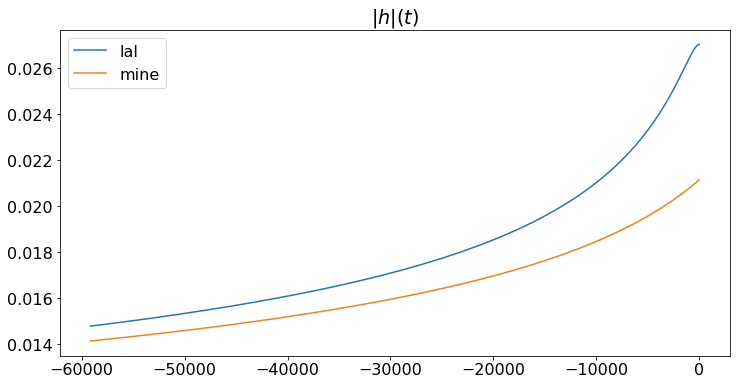

In [58]:

plt.figure(figsize=(12, 6))
plt.plot(t3_t_M, t3_amp, label='lal')
plt.plot(t3_t_M, np.abs(my_pn_22), label='mine')
plt.legend()
# plt.xlim(-6000,60)
# plt.ylim(0.2, 1.6)
# plt.yscale('log')
plt.title(r'$|h|(t)$')
plt.legend()

## PN amplitude using my IMR freq model

In [59]:
# i don't think this works super well and it's easier to just fit PN + higher-terms as in the previous section

In [60]:
# https://arxiv.org/pdf/0802.1249.pdf
def Hhat22_with_IMR_freq(t, eta=0.25, M=1):

    GW22AngFreq = i_full_freq(t)
    OrgAngFreq = GW22AngFreq/2
    
    x = (M*OrgAngFreq)**(2./3)
    
    xarr = np.zeros(6, dtype=np.complex128)
    
    C = 0.577216 # is the Euler constant

    xarr[0] = 1.
    xarr[1] = -107./42 + 55*eta/42
    xarr[2] = 2.*np.pi
    xarr[3] = -2173./1512 - 1069*eta/216 + 2047*eta**2/1512
    xarr[4] = (-107*np.pi/21 - 24*1.j*eta + 34*np.pi*eta/21) # there is an i... not sure what to do...
    
    x5a = 27027409/646800 - 856*C/105 + 428*1.j*np.pi/105 + 2*np.pi**2/3
    x5b = (-278185/33264 + 41*np.pi**2/96)*eta - 20261*eta**2/2772 + 114635*eta**3/99792
    
    x5log =  - 428*np.log(16*x)/105
    
    xarr[5] = (x5a) + x5b # there is an i...  not sure what to do...
    
    pre = np.sqrt(16*np.pi/5) * 2 * eta
    
    pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3] + x**(5/2.)*xarr[4] + x**3*(xarr[5] + x5log)
#     pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3]
#     pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2]
    
    return pre * pn * x

In [61]:
my_pn_22 = Hhat22(full_times, 1000, psi4s[k].eta, 1)

In [62]:
my_pn_22_with_IMR_freq = np.abs(Hhat22_with_IMR_freq(full_times))

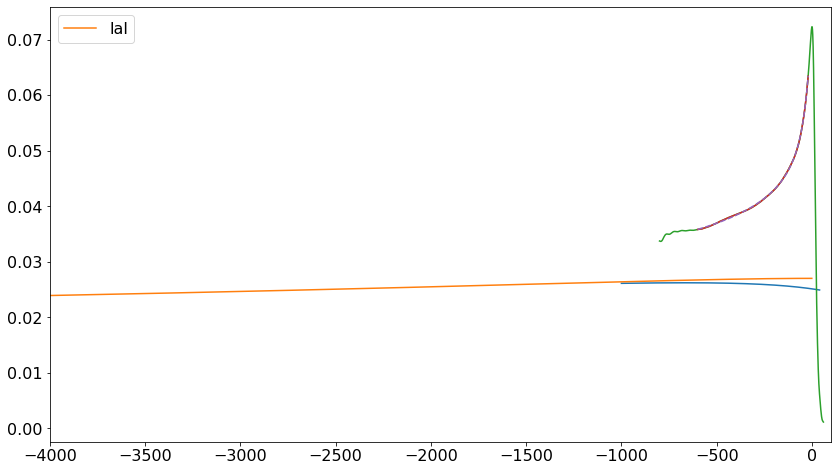

In [63]:
plt.figure(figsize=(14,8))
# plt.plot(full_times, my_pn_22_with_IMR_freq)
plt.plot(full_times, np.abs(my_pn_22))
plt.plot(t3_t_M, t3_amp, label='lal')

plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp)

plt.xlim(-4000, 100)
# plt.ylim(0.01,0.5)


plt.plot(q1_fit_amp_ins.fit_times, q1_fit_amp_ins.fit_data)
plt.plot(q1_fit_amp_ins.fit_times, q1_fit_amp_ins.freq_mr_final, ls='--')
plt.legend()

# fit inspiral amplitude using PN expression

In [64]:
# inspiral amp model
class Model_Ins_Amp_PN(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        

        t0 = params['t0']
        
        a0 = params['a0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        
        tau = (t0-t)
        
#         T3amp = np.abs(Hhat22(t, t0, self.Psi4.eta, 1))

        # note I decided to fix the tc that enters the amplitude Omega to 1000. If I didn't then the T3 PN Omega would produce negative orb frequencies at late times
        # and break (produce nans) in the PN amplitude
        T3amp = np.abs(Hhat22(t, 1000, self.Psi4.eta, 1))
        
#         model = self.T3amp_masked + a0*(t0-t)**(-7./8.) + a1*(t0-t)**(-9./8.) + a2*(t0-t)**(-10./8.) + a3*(t0-t)**(-11./8.)
#         model = self.T3amp_masked + a0*(t0-t)**(-8./8.) + a1*(t0-t)**(-9./8.) + a2*(t0-t)**(-10./8.) + a3*(t0-t)**(-11./8.)
        model = T3amp + a0*tau**(-9./8.) + a1*tau**(-10./8.) + a2*tau**(-11./8.) + a3*tau**(-12./8.)
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_freq_mr_mask]
# #         self.fit_data = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]


        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_amp[self.model_freq_mr_mask]
        
#         self.fit_data = self.Psi4.hlm_ang_freq[self.model_freq_mr_mask] - self.T3amp_masked
        
        # create a set of Parameters
        params = Parameters()
        
#         params.add('t0', value=0., min=-200, max=200, vary=True)
#         params.add('a0', value=0., min=-2000, max=200, vary=True)
#         params.add('a1', value=0., min=-4000, max=4000, vary=True)
#         params.add('a2', value=0., min=-4000, max=800, vary=True)
#         params.add('a3', value=0., min=-4000, max=2000, vary=True)


# works for q1
#         params.add('t0', value=20., min=1, max=200, vary=True)


        params.add('t0', value=30., min=10, max=400, vary=True)

        params.add('a0', value=1., min=-2000, max=200, vary=True)
        params.add('a1', value=100., min=-200, max=4000, vary=True)
        params.add('a2', value=1., min=-8000, max=800, vary=True)
        params.add('a3', value=1., min=-4000, max=5000, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3900
    # data points      = 2023
    # variables        = 5
    chi-square         = 1.7014e-05
    reduced chi-square = 8.4309e-09
    Akaike info crit   = -37605.3204
    Bayesian info crit = -37577.2587
[[Variables]]
    t0:  90.2771777 +/- 1.54351470 (1.71%) (init = 30)
    a0: -212.145625 +/- 21.8659632 (10.31%) (init = 1)
    a1:  1748.59243 +/- 137.161640 (7.84%) (init = 100)
    a2: -4186.78232 +/- 286.601799 (6.85%) (init = 1)
    a3:  3152.30371 +/- 199.763884 (6.34%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, a3) = -1.000
    C(a1, a2) = -1.000
    C(a0, a1) = -1.000
    C(a1, a3) =  1.000
    C(a0, a2) =  1.000
    C(a0, a3) = -0.999
    C(t0, a3) =  0.977
    C(t0, a2) = -0.974
    C(t0, a1) =  0.971
    C(t0, a0) = -0.968


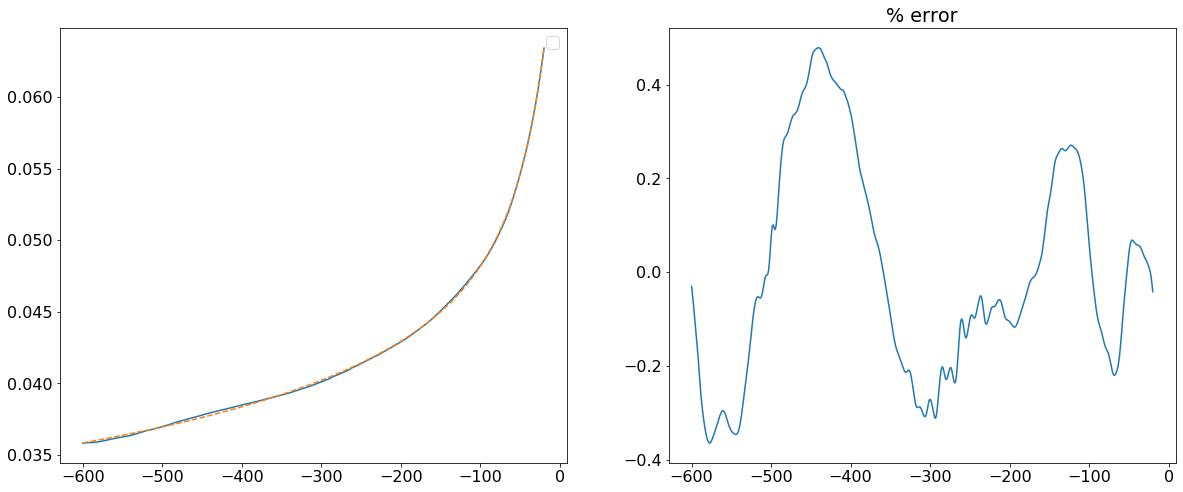

In [65]:
# k='q1'
# k='q18'

q1_fit_amp_ins_PN = Model_Ins_Amp_PN(psi4s[k])

# the current standard
q1_fit_amp_ins_PN.fit_freq_mr(t1=-600, t2=-20)

# q1_fit_amp_ins_PN.fit_freq_mr(t1=-400, t2=-100)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit_amp_ins_PN.fit_times, q1_fit_amp_ins_PN.fit_data)
axes[0].plot(q1_fit_amp_ins_PN.fit_times, q1_fit_amp_ins_PN.freq_mr_final, ls='--')


axes[1].plot(q1_fit_amp_ins_PN.fit_times, 100*(q1_fit_amp_ins_PN.fit_data - q1_fit_amp_ins_PN.freq_mr_final)/q1_fit_amp_ins_PN.fit_data)




axes[1].set_title("% error")

# axes[1].set_ylim(-0.4,0.4)


# extrapolate
# xs = np.linspace(-12000,-50,5000)


# q1_fit_amp_ins.T3amp_masked = q1_fit_amp_ins.iT3(xs)
# ys = q1_fit_amp_ins.model_freq_mr(q1_fit_amp_ins.freq_mr_result.params, xs)

# iy_nr = IUS(psi4s[k].times_hlm, psi4s[k].hlm_amp)
# y_nr = iy_nr(xs)


# axes[0].plot(xs,ys, ls='--', label='extrap fit')
# axes[0].plot(xs,y_nr, ls='--')

# axes[1].plot(xs,100*(y_nr-ys)/y_nr, ls='--')

axes[0].legend()

# axes[0].plot(t3_t_M, t3_amp)

# axes[1].set_xlim(-100, 20)

# fitting merger-ringdown strain amplitude

In [66]:
class Model_hlm_Amp(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_mr(self, params, t):
        
#         fhat = self.freq_data_y_new




        A0 = params['A0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        b = params['b']
        
        kappa = params['kappa']
        t0 = params['t0']

        fhat = ((1 + np.tanh( (t-t0)/b ))/2)**kappa
        
        den = 1. + (a1 * ( fhat**2 - fhat**4 ))
        den += a2 * (fhat**4 - fhat**6)
        den += a3 * (fhat**6 - fhat**8)
        
#         ifhat = IUS(t, fhat)
#         fhatdot = ifhat.derivative()(t)
        tanh_ab = np.tanh((t-t0)/b)
        tanh_ab_over_2_p_05 = tanh_ab/2 + 0.5

        fhatdot =  kappa*(1 - tanh_ab**2)*(tanh_ab_over_2_p_05)**kappa/(2*b*(tanh_ab_over_2_p_05))
        
#         den=1
        
#         sech = 1./np.cosh( (t-tp)/b )
#         fhatdot = sech
        
#         model = A0 * np.sqrt(np.abs(fhatdot) / den)
#         model = A0 * fhatdot / den
        model = A0 * fhatdot * den

        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_freq_mr_mask = (self.Psi4.times_news > t1) & (self.Psi4.times_news < t2)
#         self.fit_times = self.Psi4.times_news[self.model_freq_mr_mask]
#         self.fit_data = self.Psi4.newslm_amp[self.model_freq_mr_mask]**2

        self.model_freq_mr_mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.model_freq_mr_mask]
        self.fit_data = self.Psi4.hlm_amp[self.model_freq_mr_mask]**2
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('A0', value=1., min=-20, max=20)
        params.add('a1', value=0., min=-200, max=5000, vary=True)
        params.add('a2', value=0., min=-200, max=5000, vary=True)
        params.add('a3', value=0., min=-200, max=5000, vary=True)
#         params.add('b', value=2., min=1, max=200)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        
        params.add('t0', value=1., min=-200, max=200)
        params.add('kappa', value=1., min=1e-8, max=2000, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 384
    # variables        = 6
    chi-square         = 5.1762e-08
    reduced chi-square = 1.3694e-10
    Akaike info crit   = -8715.26258
    Bayesian info crit = -8691.55872
[[Variables]]
    A0:     0.37083983 +/- 0.00466939 (1.26%) (init = 1)
    a1:     5.32201058 +/- 0.21178709 (3.98%) (init = 0)
    a2:    -16.7602109 +/- 0.52959393 (3.16%) (init = 0)
    a3:     18.6959754 +/- 0.57476021 (3.07%) (init = 0)
    b:      11.25571 (fixed)
    t0:     12.8662074 +/- 0.07169920 (0.56%) (init = 1)
    kappa:  0.06333533 +/- 4.0528e-04 (0.64%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, a3)    = -1.000
    C(a1, a2)    = -0.998
    C(a1, a3)    =  0.998
    C(A0, a1)    = -0.979
    C(a3, t0)    =  0.969
    C(A0, a2)    =  0.968
    C(a1, t0)    =  0.968
    C(A0, a3)    = -0.965
    C(a2, t0)    = -0.964
    C(A0, t0)    = -0.922
    C(t0, kappa) =

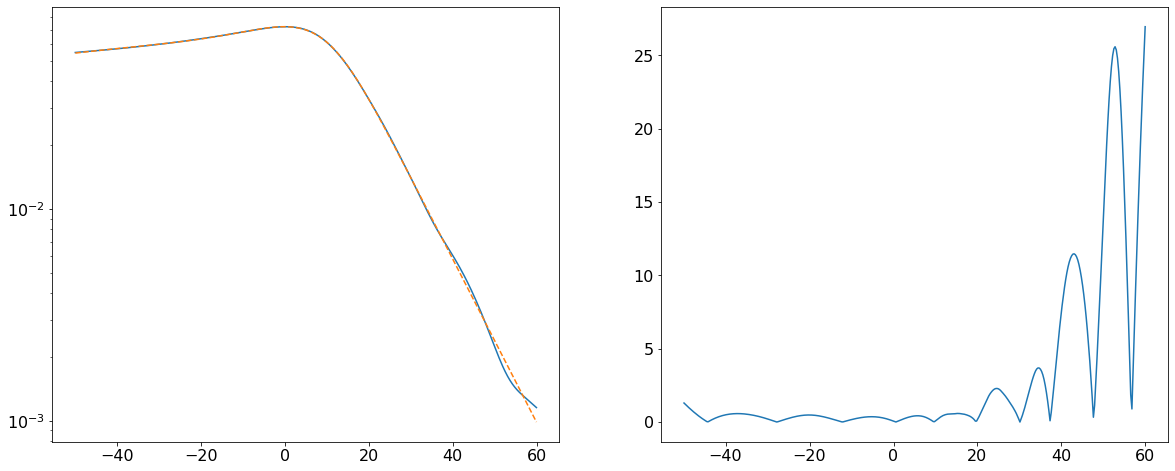

In [67]:
# k='q1'

q1_fit_mr_amp = Model_hlm_Amp(psi4s[k])
q1_fit_mr_amp.fit_freq_mr(t1=-50, t2=60)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(q1_fit_mr_amp.fit_times, np.sqrt(q1_fit_mr_amp.fit_data))
axes[0].plot(q1_fit_mr_amp.fit_times, np.sqrt(q1_fit_mr_amp.freq_mr_final), ls='--')
# axes[0].set_xlim(-30,30)
axes[0].set_yscale('log')

dnr=q1_fit_mr_amp.fit_data
dfit=q1_fit_mr_amp.freq_mr_final

axes[1].plot(q1_fit_mr_amp.fit_times, np.abs((dnr-dfit)/dnr) * 100)
# axes[1].set_yscale('log')

# put it all together

### amplitude

In [68]:
xs_ins = np.linspace(-1000, -20, 1000)
xs_mr = np.linspace(-40, 100, 500)

In [69]:
# amp inspiral model 
amp_ins_model = q1_fit_amp_ins_PN.model_freq_mr(q1_fit_amp_ins_PN.freq_mr_result.params, xs_ins)

In [70]:
# amp merger ringdown model
amp_mr_model = q1_fit_mr_amp.model_freq_mr(q1_fit_mr_amp.freq_mr_result.params, xs_mr)

In [71]:
# inspiral upto t=-20
# mr from from t=-20 until the end
ins_mask = xs_ins <= -20
mr_mask = xs_mr > -20

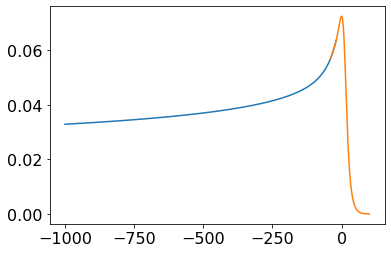

In [72]:
plt.figure()

plt.plot(xs_ins, amp_ins_model)
plt.plot(xs_mr, np.sqrt(amp_mr_model))

In [73]:
amp_imr_xs = np.concatenate((xs_ins[ins_mask], xs_mr[mr_mask]))
amp_imr_ys = np.concatenate((amp_ins_model[ins_mask], np.sqrt(amp_mr_model)[mr_mask]))

In [74]:
i_amp_imr_ys = IUS(amp_imr_xs, amp_imr_ys)

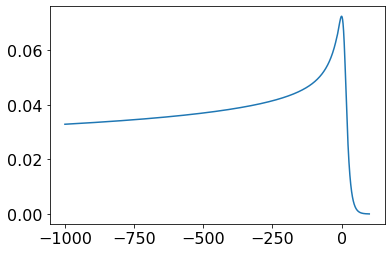

In [75]:
plt.figure()
plt.plot(amp_imr_xs, amp_imr_ys)

### frequency

In [76]:
xs_ins = np.linspace(-1000, -20, 1000)
xs_int = np.linspace(-40, -10, 500)
xs_mr = np.linspace(-40, 100, 500)

In [77]:
ins_ys = q1_fit_ins.model_freq_mr(q1_fit_ins.freq_mr_result.params, xs_ins)
int_ys = q1_fit.model_freq_mr(q1_fit.freq_mr_result.params, xs_int)
mr_ys = q1_fit_3.model_freq_mr(q1_fit_3.freq_mr_result.params, xs_mr)

In [78]:
# inspiral upto t=-40
# intermediate from t=-40 to t=-10
# mr from t=-10 until the end
# ins_mask = q1_fit_ins.fit_times <= -40
ins_mask = xs_ins <= -40
int_mask = (xs_int > -40) & (xs_int <= -10)
mr_mask = xs_mr > -10

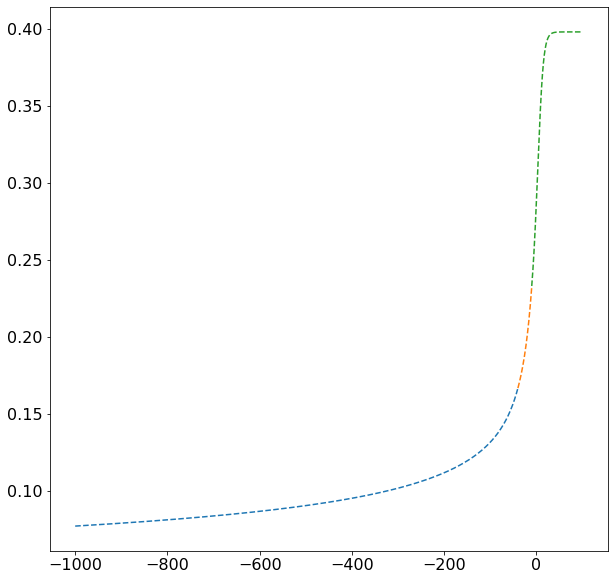

In [79]:
plt.figure(figsize=(10,10))

plt.plot(xs_ins[ins_mask], ins_ys[ins_mask], ls='--')
plt.plot(xs_int[int_mask], int_ys[int_mask], ls='--')
plt.plot(xs_mr[mr_mask], mr_ys[mr_mask], ls='--')
# plt.xlim(-100, 30)
# plt.ylim(0.14,0.3)

In [80]:
full_times = np.concatenate((xs_ins[ins_mask],xs_int[int_mask],xs_mr[mr_mask]))
full_freq = np.concatenate((ins_ys[ins_mask],int_ys[int_mask],mr_ys[mr_mask]))

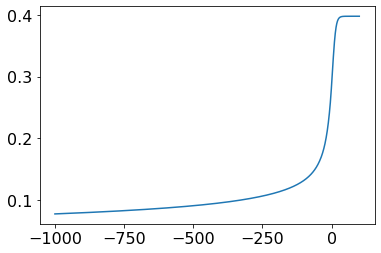

In [81]:
plt.figure()
plt.plot(full_times, full_freq)

In [82]:
i_full_freq = IUS(full_times, full_freq)

In [83]:
import scipy.integrate
def compute_integral(times, x):

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)

In [84]:
# xs_full = np.linspace(-1000, 100, 1000)
xs_full = psi4s[k].times_hlm

In [85]:
phase_model = compute_integral(xs_full, i_full_freq(xs_full))

In [86]:
amp_model = i_amp_imr_ys(xs_full)

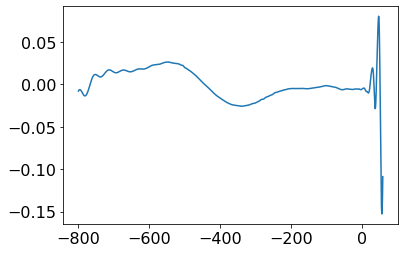

In [87]:
avg_phase_diff = np.mean(phase_model - psi4s[k].hlm_phase)

plt.figure()
plt.plot(psi4s[k].times_hlm, phase_model - psi4s[k].hlm_phase - avg_phase_diff)
# plt.ylim(-0.05,0.05)

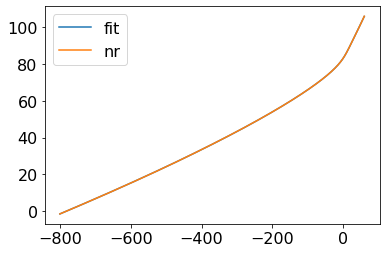

In [88]:
plt.figure()
plt.plot(xs_full, phase_model - avg_phase_diff, label='fit')
plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_phase, label='nr')
plt.legend()

Text(0.5, 1.0, 'q = 18.0')

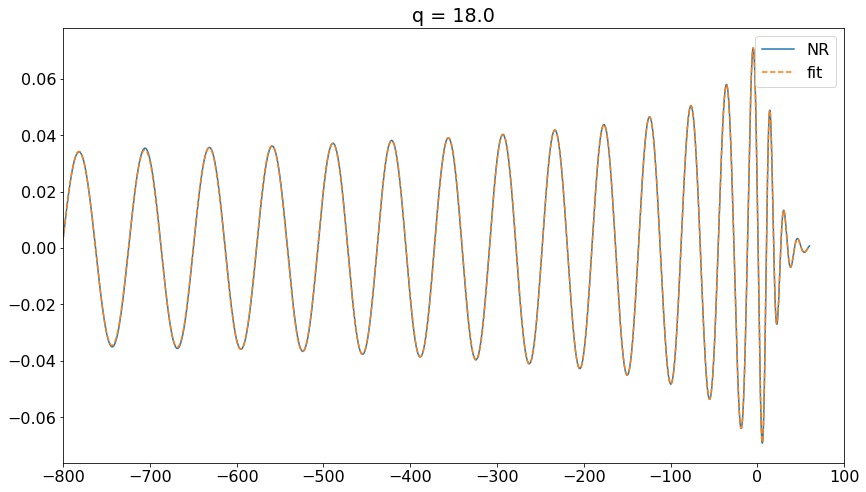

In [89]:
plt.figure(figsize=(14,8))
plt.plot(psi4s[k].times_hlm, np.real(psi4s[k].hlm_amp * np.exp(-1.j * psi4s[k].hlm_phase)), label='NR')
plt.plot(xs_full, np.real(amp_model * np.exp(-1.j * (phase_model - avg_phase_diff))), label='fit', ls='--')
plt.xlim(-800,100)
plt.legend()
plt.title('q = {}'.format(psi4s[k].q))

In [90]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [91]:
h1=psi4s[k].hlm_amp * np.exp(-1.j * psi4s[k].hlm_phase)
h2=amp_model * np.exp(-1.j * (phase_model - avg_phase_diff))

In [92]:
# match(h1,h2,xs_full)
np.max(np.abs(match(h1,h2,xs_full)))

0.9998909783472867

# parameter space fits

## frequency model classes

In [93]:
class Model_Freq_Ins(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        tc = params['tc']
        b = params['b']
        c = params['c']
        d = params['d']
        nu = self.Psi4.eta
        M = 1
        
        tau = nu * (tc - t) / (5*M)
        model = (TaylorT3_Omega_new(t, 1000, nu, M) + b*tau**(-9./8.) + c*tau**(-10./8.) + d*tau**(-11./8.))
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-600, t2=-20):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tc', value=20., min=-5, max=400)
        
        params.add('b', value=0, min=-300, max=300, vary=True)
        params.add('c', value=0., min=-2000, max=2000, vary=True)
        params.add('d', value=0., min=-2000, max=2000, vary=True)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [94]:
class Model_Freq_Int(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2 + a2 / (t - tp)**3 + a3 / (t - tp)**4
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-60, t2=-5):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tdamp', value=20., min=-1000, max=1000)
        params.add('tp', value=20, min=-300, max=300)
        params.add('lor_amp', value=20., min=-2000, max=2000)
        params.add('a0', value=0., min=-2000, max=200, vary=True)
        params.add('a1', value=0., min=-4000, max=4000, vary=False)
        params.add('a2', value=0., min=-200, max=800, vary=False)
        params.add('a3', value=0., min=-200, max=800, vary=False)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [95]:
class Model_Freq_MR(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']
        
        c = params['c']
        d = params['d']
        e = params['e']

        dt = t - t0
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * ((num/den)**(kappa))
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-10, t2=40):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('t0', value=5., min=-20, max=20)
        params.add('kappa', value=1, vary=True)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('om_f', value=self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0.2, min=1e-2, max=200)
        
        params.add('c', value=0, min=-200, max=200, vary=False)
        params.add('d', value=0, min=-200, max=200, vary=False)
        params.add('e', value=0, min=-200, max=200, vary=False)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [96]:
# qqq1 = Model_Freq_Ins(psi4s['q1'])
# qqq1 = Model_Freq_Int(psi4s['q1'])
qqq1 = Model_Freq_MR(psi4s['q1'])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 174
    # variables        = 3
    chi-square         = 2.3810e-05
    reduced chi-square = 1.3924e-07
    Akaike info crit   = -2743.97832
    Bayesian info crit = -2734.50115
[[Variables]]
    t0:      7.73545435 +/- 0.04146705 (0.54%) (init = 5)
    kappa:   0.47872303 +/- 0.00415592 (0.87%) (init = 1)
    b:       11.70642 (fixed)
    om_f:    0.5534662 (fixed)
    offset:  0.18646789 +/- 0.00119688 (0.64%) (init = 0.2)
    c:       0 (fixed)
    d:       0 (fixed)
    e:       0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, offset) =  0.989
    C(t0, kappa)     = -0.979
    C(t0, offset)    = -0.941


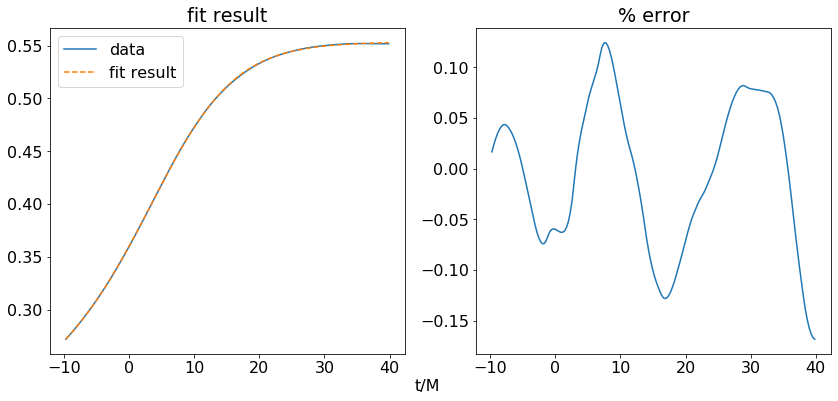

In [97]:
qqq1.fit()
qqq1.plot_result()

## amplitude model classes

In [98]:
class Model_Amp_Ins(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        t0 = params['t0']
        
        a0 = params['a0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        
        tau = (t0-t)
        
        # note I decided to fix the tc that enters the amplitude Omega to 1000. If I didn't then the T3 PN Omega would produce negative orb frequencies at late times
        # and break (produce nans) in the PN amplitude
        T3amp = np.abs(Hhat22(t, 1000, self.Psi4.eta, 1))
        
        model = T3amp + a0*tau**(-9./8.) + a1*tau**(-10./8.) + a2*tau**(-11./8.) + a3*tau**(-12./8.)
        
        return model
    
    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-600, t2=-20):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_amp[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('t0', value=30., min=10, max=400, vary=True)

        params.add('a0', value=1., min=-2000, max=200, vary=True)
        params.add('a1', value=100., min=-200, max=4000, vary=True)
        params.add('a2', value=1., min=-8000, max=800, vary=True)
        params.add('a3', value=1., min=-4000, max=5000, vary=True)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [99]:
class Model_Amp_MR(object):
    """
    the amplitude data we fit for the MR is the NR data SQUARED!
    so you have to square-root when you use the model
    """
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t, sqrt=True):
        
        A0 = params['A0']
        a1 = params['a1']
        a2 = params['a2']
        a3 = params['a3']
        b = params['b']
        
        kappa = params['kappa']
        t0 = params['t0']

        fhat = ((1 + np.tanh( (t-t0)/b ))/2)**kappa
        
        den = 1. + (a1 * ( fhat**2 - fhat**4 ))
        den += a2 * (fhat**4 - fhat**6)
        den += a3 * (fhat**6 - fhat**8)
        
#         ifhat = IUS(t, fhat)
#         fhatdot = ifhat.derivative()(t)
        tanh_ab = np.tanh((t-t0)/b)
        tanh_ab_over_2_p_05 = tanh_ab/2 + 0.5

        fhatdot =  kappa*(1 - tanh_ab**2)*(tanh_ab_over_2_p_05)**kappa/(2*b*(tanh_ab_over_2_p_05))
        
#         den=1
        
#         sech = 1./np.cosh( (t-tp)/b )
#         fhatdot = sech
        
#         model = A0 * np.sqrt(np.abs(fhatdot) / den)
#         model = A0 * fhatdot / den
        model = A0 * fhatdot * den

        if sqrt:
            return np.sqrt(model)
        else:
            return model
    
    def ansatz_to_min(self, params, t, data, sqrt=False):
        model = self.ansatz(params, t, sqrt=sqrt)
        return model - data
        
    def fit(self, t1=-50, t2=60):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_amp[self.mask]
        
        
        # we fit the square of the data for the amp model
        self.fit_data = self.fit_data**2
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('A0', value=1., min=-20, max=20)
        params.add('a1', value=0., min=-200, max=5000, vary=True)
        params.add('a2', value=0., min=-200, max=5000, vary=True)
        params.add('a3', value=0., min=-200, max=5000, vary=True)
#         params.add('b', value=2., min=1, max=200)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        
        params.add('t0', value=1., min=-200, max=200)
        params.add('kappa', value=1., min=1e-8, max=2000, vary=True)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params, self.fit_times, sqrt=False)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')


        
        plt.show()
        plt.close()

In [100]:
qqq2 = Model_Amp_Ins(psi4s['q1'])
# qqq2 = Model_Amp_MR(psi4s['q1'])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4314
    # data points      = 2023
    # variables        = 5
    chi-square         = 6.7154e-07
    reduced chi-square = 3.3277e-10
    Akaike info crit   = -44144.0578
    Bayesian info crit = -44115.9961
[[Variables]]
    t0:  56.5953290 +/- 0.06040737 (0.11%) (init = 30)
    a0: -203.068701 +/- 2.02283321 (1.00%) (init = 1)
    a1:  2219.79902 +/- 12.4054025 (0.56%) (init = 100)
    a2: -5643.57387 +/- 25.3819651 (0.45%) (init = 1)
    a3:  4309.50611 +/- 17.3752750 (0.40%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2) = -1.000
    C(a0, a1) = -1.000
    C(a2, a3) = -1.000
    C(a0, a2) =  0.999
    C(a1, a3) =  0.999
    C(a0, a3) = -0.999
    C(t0, a3) =  0.974
    C(t0, a2) = -0.970
    C(t0, a1) =  0.966
    C(t0, a0) = -0.962


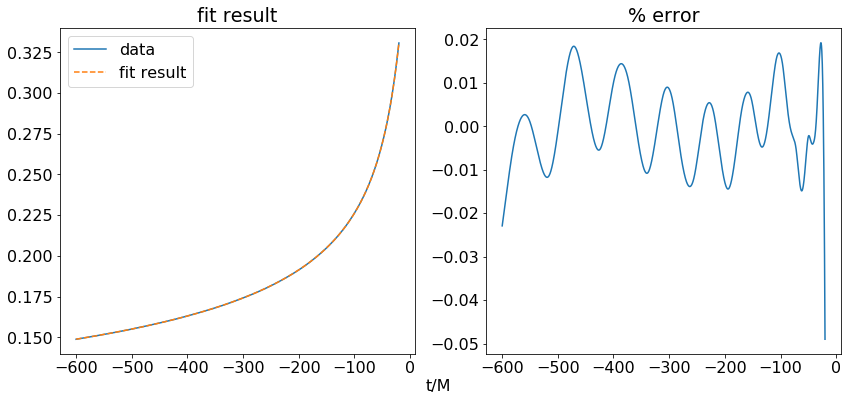

In [101]:
qqq2.fit()
qqq2.plot_result()